# Classificando HPAs

Percorre os arquivos baixados por `hpa_usage.ipynb` no diretório `search_results` e classifica-os de acordo com suas características.

In [17]:
import os
import subprocess
import re
import yaml
from datetime import datetime, timedelta
from pathlib import Path

from joblib import Parallel, delayed
from dotenv import dotenv_values
from ghapi.core import GhApi, HTTP422UnprocessableEntityError, HTTP404NotFoundError, HTTP403ForbiddenError
from ghapi.page import paged
import pandas as pd
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

import utils

pd.set_option('display.max_colwidth', 2000)

# Tema padrão para os gráficos
plt.style.use('bmh')


## Definição de funções

In [18]:
def is_helm_template(content):
    # Detects Helm template patterns in the file content
    return bool(re.search(r'{{.*}}', content))


def parse_yaml_documents(content):
    # Parses YAML content into a list of documents
    try:
        return list(yaml.safe_load_all(content))
    except yaml.YAMLError:
        return []


def extract_metrics_from_spec(spec, debug=False):
    # Extracts metric information from the HPA spec
    metrics_info = []
    metrics = spec.get('metrics', [])
    if debug:
        print("Extracting metrics")
        print(metrics)

    for metric in metrics:
        if isinstance(metric, str):
            metrics_info.append({
                'Metric Name': metric,
                'Metric Type': metric,
                'Target Value': metrics[metric]
            })
        elif not 'type' in metric:
            metrics_info.append({
                'Metric Name': 'CPUUtilizationPercentage',
                'Metric Type': 'CPUUtilizationPercentage',
                'Target Value': spec['CPUUtilizationPercentage']
            })
        else:
            if debug:
                print(f"type {metric.get('type', 'NA')}")
            metric_type = metric.get('type', '')
            metric_details = metric.get(metric_type.lower(), {})
            target = metric_details.get('target', {})
            target_value = target.get('averageValue') or target.get(
                'averageUtilization') or target.get('targetAverageUtilization') or target.get('value')

            metric_name = ''
            if metric_type.lower() == 'resource':
                metric_name = metric_details.get('name', '')
            else:
                metric_name = metric_details.get('metric', {}).get('name', '')

            metrics_info.append({
                'Metric Name': metric_name,
                'Metric Type': metric_type,
                'Target Value': target_value
            })
    if not metrics:
        if 'targetCPUUtilizationPercentage' in spec:
            metrics_info.append({
                'Metric Name': 'targetCPUUtilizationPercentage',
                'Metric Type': 'targetCPUUtilizationPercentage',
                'Target Value': spec['targetCPUUtilizationPercentage']
            })
        if 'cpuUtilization' in spec:
            if debug:
                print(spec['cpuUtilization'].keys())
            metrics_info.append({
                'Metric Name': 'cpuUtilization',
                'Metric Type': 'cpuUtilization',
                'Target Value': spec['cpuUtilization']['targetPercentage']
            })
    return metrics_info


def extract_behavior_from_spec(spec, debug=False):

    behavior = spec.get('behavior', None)
    if behavior is None:
        return None

    scale_up = behavior.get('scaleUp', None)
    scale_down = behavior.get('scaleDown', None)

    if debug:
        print(f"scale_up: {scale_up}")
        print(f"scale_down: {scale_down}")

    if scale_up == None and scale_down == None:
        return None

    result = {
        "scaleUp": None,
        "scaleDown": None
    }

    if scale_up:
        result["scaleUp"] = {
            "stab_window": scale_up.get('stabilizationWindowSeconds', None),
            "select_pol": scale_up.get('selectPolicy', None),
            "policies": [{
                "type": p.get('type', ''),
                "value": p.get('value', 0),
                "periodSeconds": p.get('periodSeconds', 0)
            } for p in scale_up.get('policies', [])]
        }

    if scale_down:
        result["scaleDown"] = {
            "stab_window": scale_down.get('stabilizationWindowSeconds', None),
            "select_pol": scale_down.get('selectPolicy', None),
            "policies": [{
                "type": p.get('type', ''),
                "value": p.get('value', 0),
                "periodSeconds": p.get('periodSeconds', 0)
            } for p in scale_down.get('policies', [])]
        }

    return result


def process_yaml_content(content, debug=False):
    helm_template = is_helm_template(content)

    if helm_template:
        return [{
            'hpa_count': 0,
            'apiVersion': None,
            'Is Helm Template': True
        }]

    documents = parse_yaml_documents(content)
    if debug:
        print(f"Found {len(documents)} documents")
    hpa_definitions = []

    for doc in documents:
        if isinstance(doc, dict) and doc.get('kind') == 'HorizontalPodAutoscaler':
            if debug:
                print(f"Found hpa #{len(hpa_definitions)+1}")
            api_version = doc.get('apiVersion', '')
            spec = doc.get('spec', {})

            metrics = extract_metrics_from_spec(spec, debug)
            behavior = extract_behavior_from_spec(spec, debug)
            if debug:
                print(f"with {len(metrics)} metrics")
            hpa_definitions.append({
                'hpa_count': len(hpa_definitions)+1,
                'apiVersion': api_version,
                'Is Helm Template': helm_template,
                'Metrics': metrics,
                'Behavior': behavior
            })
    return hpa_definitions


def process_yaml_file(file_path, debug=False):
    # Processes a single YAML file to extract HPA definitions and metrics
    if debug:
        print(f"Processing {file_path}")
    with open(file_path, 'r') as f:
        content = f.read()
        return process_yaml_content(content, debug=debug)


def map_version(api_version):
    # Etiqueta versão do HPA
    # Tudo que contém 'v1' e não contém 'v2' será considerado v1.
    # Caso contrário, consideramos v2.
    if 'v1' in api_version and 'v2' not in api_version:
        return 'v1'
    else:
        return 'v2'


def add_labels(plt, x, y, hpadding=0):
    for i in range(len(x)):
        plt.text(i, y[i]+hpadding, y[i], ha='center')


def wait_for_reset(resource):
    limit = github.rate_limit.get()['resources'][resource]
    reset_time = datetime.fromtimestamp(limit['reset'])
    now = datetime.today().replace(microsecond=0)
    if limit['remaining'] <= 1:
        sleep_duration = reset_time - now
        if sleep_duration.total_seconds() < 0:
            sleep_duration = timedelta(seconds=60)
        print(f"Waiting for {sleep_duration.total_seconds()} seconds")
        time.sleep(sleep_duration.total_seconds())


def get_repo_details(row):
    wait_for_reset('core')

    owner = row['Owner']
    repo = row['Project']

    try:
        repo_details = github.repos.get(owner=owner, repo=repo)
    except HTTP403ForbiddenError:
        print("Limit reached")
        wait_for_reset('core')
        repo_details = github.repos.get(owner=owner, repo=repo)
    except (HTTP404NotFoundError, fastcore.net.HTTP404NotFoundError):
        return {
            'stargazers_count': None,
            'created_at': None,
            'pushed_at': None
        }

    data = {
        'stargazers_count': repo_details['stargazers_count'],
        'created_at': repo_details['created_at'],
        'pushed_at': repo_details['pushed_at']
    }

    return pd.DataFrame(data=data, index=[row.name])


def get_file_commits(row):
    wait_for_reset('core')

    # 'File Path' representa o arquivo local, necessário extrair o caminho dele no repositório
    root_dir = "search_results"
    owner = row['Owner']
    repo = row['Project']
    file_path = row['File Path']
    local_path = Path(root_dir, owner, repo)
    path = Path(file_path).relative_to(local_path)

    try:
        commits = paged(github.repos.list_commits, owner=owner, repo=repo, path=path, per_page=100)
    except HTTP403ForbiddenError:
        print("Limit reached")
        wait_for_reset('core')
        commits = paged(github.repos.list_commits, owner=owner, repo=repo, path=path, per_page=100)
    except (HTTP404NotFoundError, fastcore.net.HTTP404NotFoundError):
        return {
            'file_committed_at': None,
            'message': None
        }

    return [item for page in commits for item in page]


def get_file_last_commit(row):
    commits = get_file_commits(row)

    if len(commits) == 0:
        return {
            'file_committed_at': None,
            'message': None
        }

    data = {
        'file_committed_at': commits[0]['commit']['author']['date'],
        'message': commits[0]['commit']['message']
    }

    return pd.DataFrame(data=data, index=[row.name])


## Processamento dos arquivos HPA

In [19]:
metrics_data = []
behavior_data = []
root_dir = 'search_results'
processing_failed = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        file_path = os.path.join(dirpath, filename)

        rel_path = os.path.relpath(dirpath, root_dir)
        path_parts = rel_path.split(os.sep)

        owner = None
        project = None
        rest = None

        if len(path_parts) >= 2:
            owner = path_parts[0]
            project = path_parts[1]
            rest = os.sep.join(path_parts[2:])
        file_subpath = os.path.join(rest, filename)

        try:
            hpa_definitions = process_yaml_file(file_path)
        except:
            print(f"Error processing {file_path}")
            hpa_definitions = []
        for hpa in hpa_definitions:
            has_behavior = 'Behavior' in hpa and hpa['Behavior'] is not None
            # metrics
            if not 'Metrics' in hpa:
                metrics_data.append({
                    'Owner': owner,
                    'Project': project,
                    'File Path': file_path,
                    'hpa_count': hpa['hpa_count'],
                    'apiVersion': hpa['apiVersion'],
                    'Is Helm Template': hpa['Is Helm Template'],
                    'Metric Name': None,
                    'Metric Type': None,
                    'Target Value': None,
                    'Has Behavior': has_behavior
                })
            else:
                metrics = hpa['Metrics']
                for metric in metrics:
                    metrics_data.append({
                        'Owner': owner,
                        'Project': project,
                        'File Path': file_path,
                        'hpa_count': hpa['hpa_count'],
                        'apiVersion': hpa['apiVersion'],
                        'Is Helm Template': hpa['Is Helm Template'],
                        'Metric Name': metric['Metric Name'],
                        'Metric Type': metric['Metric Type'],
                        'Target Value': metric['Target Value'],
                        'Has Behavior': has_behavior
                    })
                if not metrics:
                    metrics_data.append({
                        'Owner': owner,
                        'Project': project,
                        'File Path': file_path,
                        'hpa_count': hpa['hpa_count'],
                        'apiVersion': hpa['apiVersion'],
                        'Is Helm Template': hpa['Is Helm Template'],
                        'Metric Name': None,
                        'Metric Type': None,
                        'Target Value': None,
                        'Has Behavior': has_behavior
                    })
        if not hpa_definitions:
            processing_failed.append(file_path)
            metrics_data.append({
                'Owner': owner,
                'Project': project,
                'File Path': file_path,
                'Is Helm Template': None,
                'Metric Name': None,
                'Metric Type': None,
                'Target Value': None,
                'Has Behavior': False
            })

# display(processing_failed)


Error processing search_results/Eldarrin/deepsea/src/main/fabric8/HorizontalPodAutoscaler.yml


In [20]:
df = pd.DataFrame(metrics_data)

df['hpa_count'] = df['hpa_count'].fillna(0).apply(lambda x: int(x))

display(df)


,Owner,Project,File Path,hpa_count,apiVersion,Is Helm Template,Metric Name,Metric Type,Target Value,Has Behavior
0,0GiS0,tour-of-heroes-gitops-demos,search_results/0GiS0/tour-of-heroes-gitops-demos/helm/tour-of-heroes-chart/charts/api/templates/hpa.yaml,0,None,True,None,None,None,False
1,0hlov3,charts,search_results/0hlov3/charts/charts/element-web/templates/hpa.yaml,0,None,True,None,None,None,False
2,18F,identity-dashboard,search_results/18F/identity-dashboard/dockerfiles/application.yaml,0,None,True,None,None,None,False
3,18F,identity-loadtest,search_results/18F/identity-loadtest/coredns.yaml,1,autoscaling/v2,False,cpu,Resource,70,False
4,18F,identity-pki,search_results/18F/identity-pki/k8files/application.yaml,0,None,True,None,None,None,False
...,...,...,...,...,...,...,...,...,...,...
1518,zuisong,vertx-server-push,search_results/zuisong/vertx-server-push/k8s.yml,0,NaN,None,None,None,None,False
1519,zxcvbnius,k8s-30-day-sharing,search_results/zxcvbnius/k8s-30-day-sharing/Day25/demo-hpa/helloworld-hpa.yaml,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,50,False
1520,agntcy,dir,search_results/agntcy/dir/install/charts/dir/apiserver/templates/hpa.yaml,0,None,True,None,None,None,False
1521,kbj0109,kbj-nestjs-backend,search_results/kbj0109/kbj-nestjs-backend/infra/hpa.yaml,1,autoscaling/v2beta2,False,requests_per_second,Pods,2,False


## Filtra as entradas relativas a Templates Helm

No geral, estes arquivos não apresentam _metrics_ nem _behaviors_, e os valores destas propriedades são definidos nos arquivos _values.yml_ do chart.

In [21]:
filter_nohelm = df[df['Is Helm Template'] == False]

display(filter_nohelm)


,Owner,Project,File Path,hpa_count,apiVersion,Is Helm Template,Metric Name,Metric Type,Target Value,Has Behavior
3,18F,identity-loadtest,search_results/18F/identity-loadtest/coredns.yaml,1,autoscaling/v2,False,cpu,Resource,70,False
12,Abxtracted,abxtracted,search_results/Abxtracted/abxtracted/k8s/hpa.yml,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,85,False
16,Ahoo-Wang,CoSec,search_results/Ahoo-Wang/CoSec/k8s/cosec-gateway-hpa.yaml,1,autoscaling/v2,False,cpu,Resource,600,False
17,AhmadRafiee,DevOps_Certification,search_results/AhmadRafiee/DevOps_Certification/kubernetes/scenario/auto-scaling/php-app/04.php-hpa.yml,1,autoscaling/v2,False,cpu,Resource,50,True
18,AhmadRafiee,DevOps_Certification,search_results/AhmadRafiee/DevOps_Certification/kubernetes/scenario/auto-scaling/php-app/04.php-hpa.yml,1,autoscaling/v2,False,memory,Resource,30,True
...,...,...,...,...,...,...,...,...,...,...
1515,zilliztech,milvus-operator,search_results/zilliztech/milvus-operator/config/samples/hpa.yaml,1,autoscaling/v2,False,memory,Resource,60,True
1516,zjzjzjzj1874,best-practice-go-zero,search_results/zjzjzjzj1874/best-practice-go-zero/task/task-k8s.yaml,1,autoscaling/v2beta1,False,cpu,Resource,None,False
1517,zjzjzjzj1874,best-practice-go-zero,search_results/zjzjzjzj1874/best-practice-go-zero/task/task-k8s.yaml,2,autoscaling/v2beta1,False,memory,Resource,None,False
1519,zxcvbnius,k8s-30-day-sharing,search_results/zxcvbnius/k8s-30-day-sharing/Day25/demo-hpa/helloworld-hpa.yaml,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,50,False


## Números Gerais dos dados encontrados

In [22]:
print("Após remover os templates helm, restaram")
print(f"{filter_nohelm[['Owner', 'Project', 'File Path', 'hpa_count', 'apiVersion']].drop_duplicates().shape[0]} definições HPA")
print(
    f"em {filter_nohelm[['Owner', 'Project', 'File Path']].drop_duplicates().shape[0]} arquivos")
print(
    f"de {filter_nohelm[['Owner', 'Project']].drop_duplicates().shape[0]} projetos")
print(
    f"por {filter_nohelm['Owner'].drop_duplicates().shape[0]} autores (owners)")
print(
    f"{filter_nohelm[filter_nohelm['Has Behavior']!=False].shape[0]} definições HPA apresentam behavior")


Após remover os templates helm, restaram
595 definições HPA
em 459 arquivos
de 359 projetos
por 334 autores (owners)
57 definições HPA apresentam behavior


# Dados sobre os Arquivos e Definições HPA encontradas

## Quantidades de Arquivos por Projeto

,,File Path
Owner,Project,
rytswd,get-istio-multicluster,7


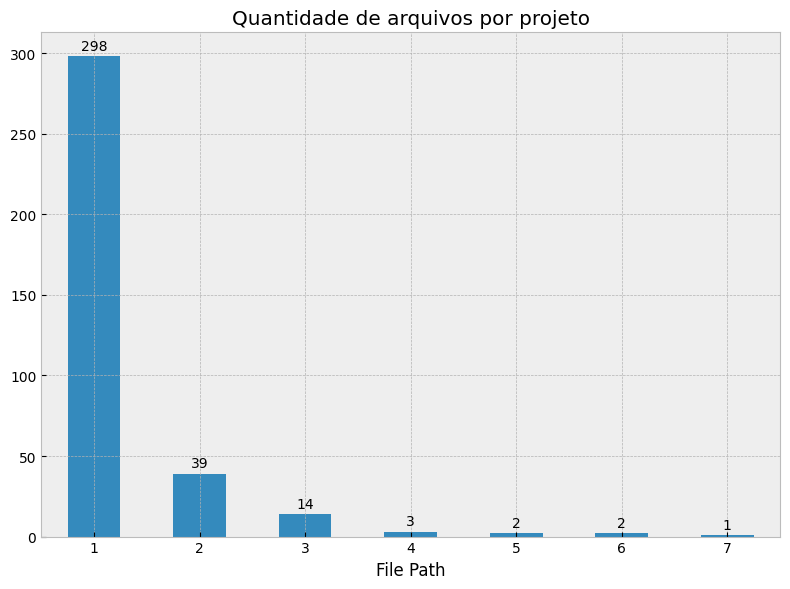

In [23]:
files_per_project = filter_nohelm[[
    'Owner', 'Project', 'File Path']].drop_duplicates()

files_counts = files_per_project.groupby(['Owner', 'Project']).count()

files_counts_values = files_counts['File Path'].value_counts()

display(files_counts[files_counts['File Path'] == 7])

plt.figure(figsize=(8, 6))

ax = files_counts_values.plot(
    kind='bar', stacked=True, ax=plt.gca())
ax.tick_params(axis="x", rotation=0)
add_labels(plt, files_counts_values.index,
           files_counts_values.values, hpadding=4)
plt.title("Quantidade de arquivos por projeto")
plt.tight_layout()
plt.show()


A maioria dos projetos tem apenas 1 arquivo com definição HPA

## Versões de HPA encontradas

'595'

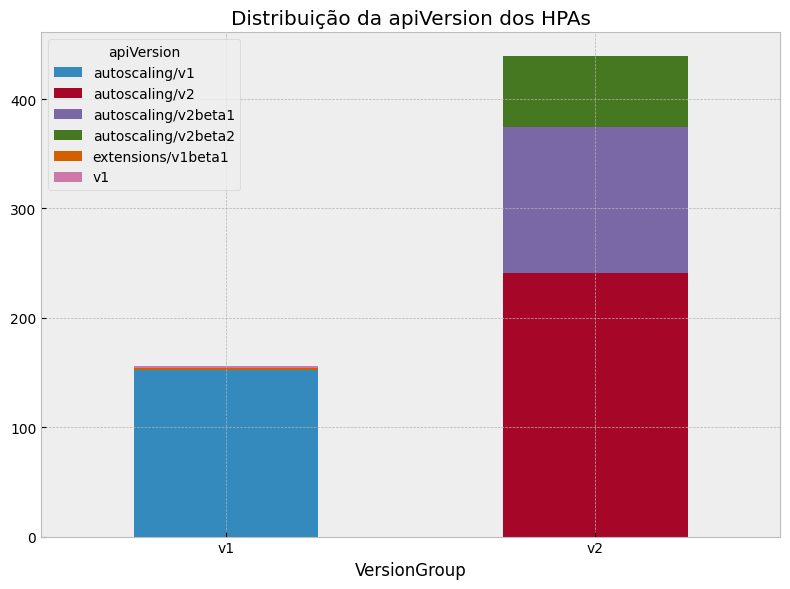

apiVersion,autoscaling/v1,autoscaling/v2,autoscaling/v2beta1,autoscaling/v2beta2,extensions/v1beta1,v1,Total
VersionGroup,,,,,,,
v1,152.0,0.0,0.0,0.0,2.0,2.0,156.0
v2,0.0,241.0,133.0,65.0,0.0,0.0,439.0


In [24]:
df_hpa_defs = filter_nohelm[[
    'Owner', 'Project', 'File Path', 'hpa_count', 'apiVersion']].drop_duplicates()

display(f"{df_hpa_defs.shape[0]}")

version_counts = df_hpa_defs['apiVersion'].value_counts().sort_index()
df_grouped = pd.DataFrame(
    {'apiVersion': version_counts.index, 'count': version_counts.values})

df_grouped['VersionGroup'] = df_grouped['apiVersion'].apply(func=map_version)

pivot_versions = df_grouped.pivot(
    index='VersionGroup', columns='apiVersion', values='count').fillna(0)

plt.figure(figsize=(8, 6))
ax = pivot_versions.plot(kind='bar', stacked=True, ax=plt.gca())
# add_labels(plt, pivot_versions.index, pivot_versions.values, hpadding=4)
ax.tick_params(axis="x", rotation=0)
plt.title("Distribuição da apiVersion dos HPAs")
plt.tight_layout()
plt.show()

pivot_versions['Total'] = pivot_versions.sum(axis=1)
display(pivot_versions)


Das definições HPA encontradas, cerca de 26% estão utilizando a versão v1 enquanto cerca de 74% utilizam a versão v2 em alguma de suas variações (v2beta1 ou v2beta2).

## Definições de HPA por arquivo

Em alguns projetos, um único arquivo yaml pode ter várias definições de HPA.

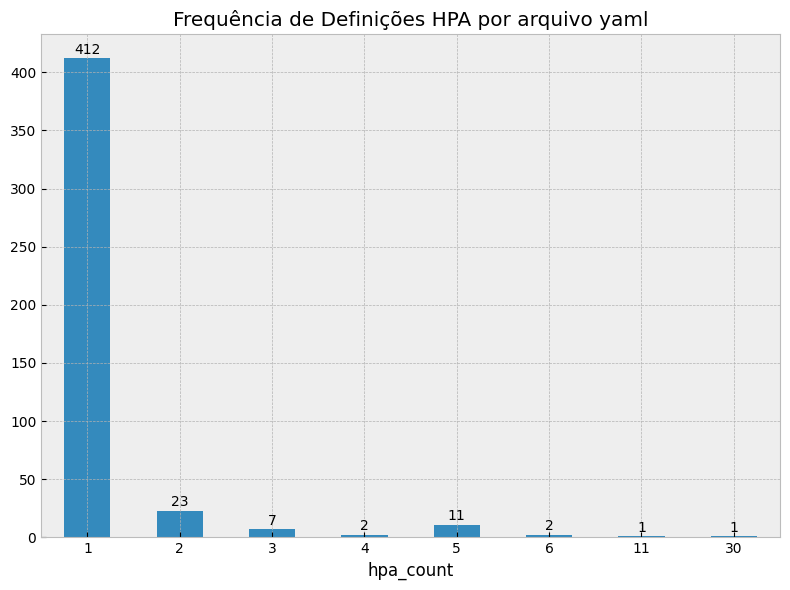

1332    search_results/solo-io/service-mesh-for-less-blog/tiered-app/30-namespace-app/ambient/waypoints/hpa-per-namespace.yaml
Name: File Path, dtype: object

1467    search_results/vigsachi/erlang/models/online_boutique/mem_autoscale/mem_autoscale_30.yaml
Name: File Path, dtype: object

In [25]:
filter_nohelm_nodups = (
    filter_nohelm
    .sort_values('hpa_count', ascending=False)
    .drop_duplicates(subset=['Owner', 'Project', 'File Path'], keep='first')
)

hpa_counts = filter_nohelm_nodups['hpa_count'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
ax = hpa_counts.plot(kind='bar')
add_labels(plt, hpa_counts.index, hpa_counts.values, hpadding=4)
ax.tick_params(axis="x", rotation=0)
plt.title("Frequência de Definições HPA por arquivo yaml")
plt.tight_layout()
plt.show()

display(
    filter_nohelm_nodups[filter_nohelm_nodups['hpa_count'] == 30]['File Path'])
display(
    filter_nohelm_nodups[filter_nohelm_nodups['hpa_count'] == 11]['File Path'])


Dos 458 arquivos identificados, 411 contém apenas 1 definição HPA. Alguns projetos apresentam arquivos com até 30 definições HPA.

## Tipos de métrica por definição HPA

23 definições HPA não apresentam métricas (usam os valores padrão)


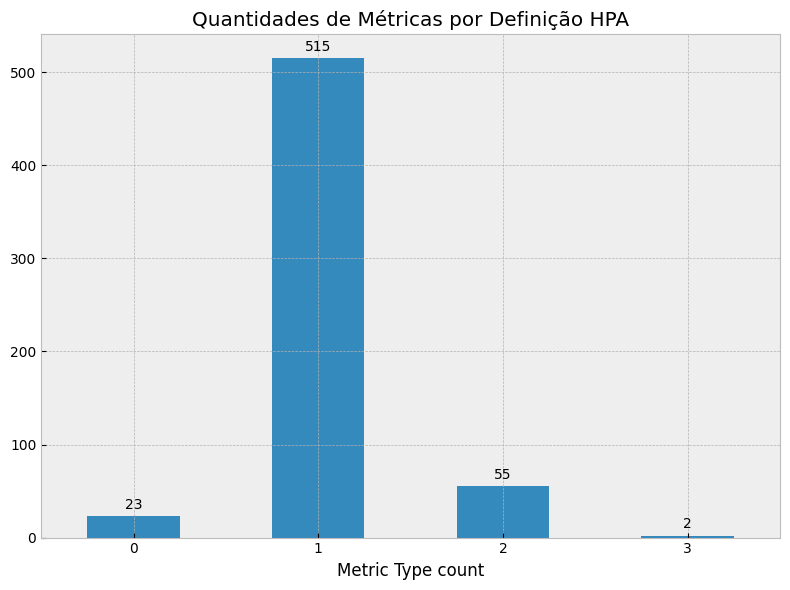

154    search_results/arafkarsh/k8s-quickstart/colima/Yamls/app/fusion-12-water-product-hpa-green.yaml
417                 search_results/ptrstpp950/k8s-allegro/exercises/28-kctl-hpa-scaling/template2.yaml
Name: File Path, dtype: object


In [26]:
files_n_def = filter_nohelm[['File Path', 'hpa_count']].drop_duplicates()
# display(files_n_def.shape[0])

metrics_per_def = filter_nohelm.groupby(['File Path', 'hpa_count'])[
    'Metric Type'].count().reset_index(name='Metric Type count')

zero_metrics = metrics_per_def[metrics_per_def['Metric Type count'] == 0]
# display(zero_metrics)
print(
    f"{zero_metrics.shape[0]} definições HPA não apresentam métricas (usam os valores padrão)")

metrics_counts = metrics_per_def['Metric Type count'].value_counts(
).sort_index()

plt.figure(figsize=(8, 6))
ax = metrics_counts.plot(kind='bar')
add_labels(plt, metrics_counts.index, metrics_counts.values, hpadding=8)
ax.tick_params(axis="x", rotation=0)
plt.title("Quantidades de Métricas por Definição HPA")
plt.tight_layout()
plt.show()

print(metrics_per_def[metrics_per_def['Metric Type count'] == 3]['File Path'])


# Tipos de Métricas

Investigando quais tipos de métricas são mais utilizadas, e quais métricas além das mais comuns (CPU e memória) são populares.

Para este passo, serão consideradas apenas as definições v2, já que as v1 contém apenas CPU e memória.

498

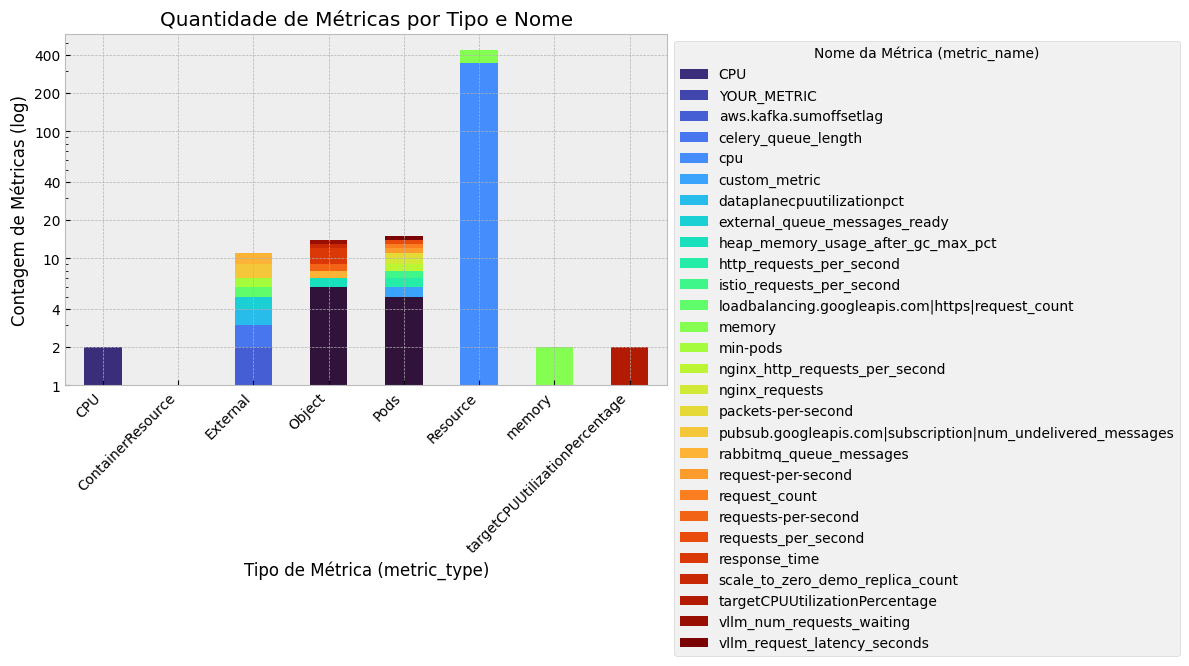

In [27]:
from matplotlib.ticker import LogLocator, FormatStrFormatter
df_v2 = filter_nohelm[filter_nohelm['apiVersion'].str.contains('v2')]
display(df_v2.shape[0])

v2_metrics = df_v2.groupby(
    ['Metric Type', 'Metric Name']).size().reset_index(name='counts')

pivot_table = v2_metrics.pivot(
    index='Metric Type', columns='Metric Name', values='counts').fillna(0)


fig = plt.figure(figsize=(12, 6))
pivot_table.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='turbo')
ax = plt.gca()
ax.set_yscale('log')
ax.yaxis.set_major_locator(LogLocator(base=10, subs=[1, 2, 4]))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.title('Quantidade de Métricas por Tipo e Nome')
plt.xlabel('Tipo de Métrica (metric_type)')
plt.ylabel('Contagem de Métricas (log)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Nome da Métrica (metric_name)', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


As métricas do tipo Resource ofuscam os outros tipos devido à sua popularidade. O tipo ContainerResource apresenta 1 métrica que está escondida devido a escala logarítmica.

Abaixo são apresentados os mesmos valores removendo este tipo de métrica e utilizando escala linear.

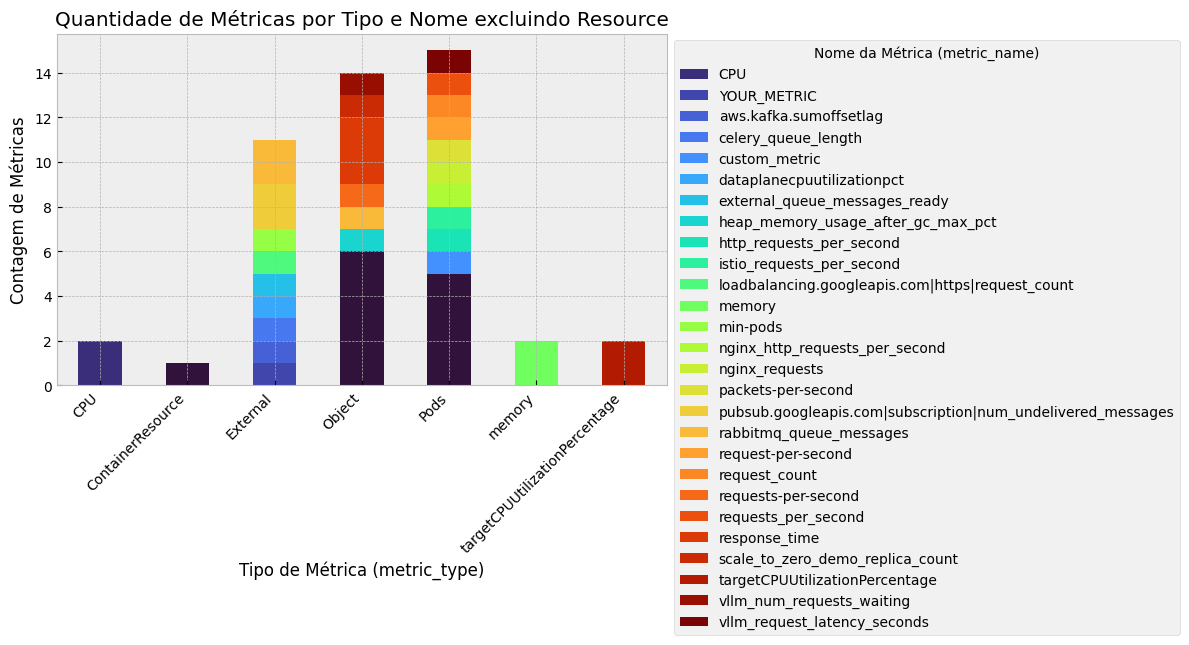

In [28]:
df_v2 = filter_nohelm[filter_nohelm['apiVersion'].str.contains('v2')]

df_v2_no_resource = df_v2[df_v2['Metric Type'] != 'Resource']

# display(df_v2_no_resource[df_v2_no_resource['Metric Type'] == 'External'])

v2_metrics = df_v2_no_resource.groupby(
    ['Metric Type', 'Metric Name']).size().reset_index(name='counts')

pivot_table = v2_metrics.pivot(
    index='Metric Type', columns='Metric Name', values='counts').fillna(0)

plt.figure(figsize=(12, 6))
pivot_table.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='turbo')
plt.title('Quantidade de Métricas por Tipo e Nome excluindo Resource')
plt.xlabel('Tipo de Métrica (metric_type)')
plt.ylabel('Contagem de Métricas')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Nome da Métrica (metric_name)', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


# Commits dos Projetos e Arquivos

Buscar relações entre as datas de criação dos projetos, últimos commits neles e últimos commits nos arquivos

In [29]:
config = {
    **os.environ,
    **dotenv_values(".env")
}
github = GhApi(token=config['GITHUB_TOKEN'])


Dados do repositório

In [30]:
wait_for_reset('core')

repos_details = Parallel(n_jobs=32)(
    delayed(get_repo_details)(row) for _, row in filter_nohelm_nodups.iterrows()
)


In [31]:
df_details = pd.concat(repos_details)
display(df_details)


,stargazers_count,created_at,pushed_at
1332,3,2024-03-14T00:05:33Z,2024-06-24T16:23:15Z
1467,7,2024-03-02T23:08:27Z,2024-11-11T00:24:46Z
1269,6,2018-05-27T03:24:33Z,2023-11-30T02:52:04Z
353,8,2022-04-18T00:04:54Z,2025-03-06T23:01:54Z
195,4,2022-05-19T12:06:59Z,2023-01-06T10:06:05Z
...,...,...,...
532,6,2023-05-12T03:11:46Z,2023-08-08T03:23:12Z
535,13,2019-06-25T11:17:48Z,2022-07-01T07:03:27Z
536,5,2023-10-12T00:23:42Z,2024-10-10T20:35:12Z
537,5,2023-10-12T00:23:42Z,2024-10-10T20:35:12Z


Dados de commit do arquivo que contém HPA

In [32]:
wait_for_reset('core')

paths_committed_at = Parallel(n_jobs=32)(
    delayed(get_file_last_commit)(row) for _, row in filter_nohelm_nodups.iterrows()
)


In [33]:
df_committed_at = pd.concat(paths_committed_at)
display(df_committed_at)


,file_committed_at,message
1332,2024-05-15T20:20:52Z,add l4/l7 policy
1467,2024-03-02T23:11:40Z,"added all code for setup, training, evaluation"
1269,2023-11-30T02:51:53Z,update Kubernetes v1.29ansible playbook
353,2022-12-13T07:04:55Z,"feat(blueprint): awsfis blueprint (#69)\n\n* feat(fis): awsfis blueprint\r\n\r\n* docs(fis): awsfis blueprint url\r\n\r\n* fix(blueprint): remove filters from the reboot db experiment\r\n\r\n* fix(blueprint): add elasticache subnet group\r\n\r\n* fix(blueprint): update default values\r\n\r\n* fix(blueprint): update module dependencies\r\n\r\n* fix(blueprint): modify module name\r\n\r\n* fix(blueprint): remove vpc dependency from eks\r\n\r\n* feat(blueprint): lamp, redispy build projects"
195,2022-05-19T12:37:17Z,Initial commit.
...,...,...
532,2023-08-08T03:23:06Z,averageValue 10
535,2019-09-20T18:58:20Z,wip
536,2024-04-09T14:54:50Z,rename subdirs
537,2024-04-12T19:42:34Z,add sample grafana prometheus


Join dos dados obtidos com o filter_nohelm em um novo DataFrame

In [34]:
items_details = filter_nohelm_nodups.join([df_details, df_committed_at])

display(items_details)


,Owner,Project,File Path,hpa_count,apiVersion,Is Helm Template,Metric Name,Metric Type,Target Value,Has Behavior,stargazers_count,created_at,pushed_at,file_committed_at,message
1332,solo-io,service-mesh-for-less-blog,search_results/solo-io/service-mesh-for-less-blog/tiered-app/30-namespace-app/ambient/waypoints/hpa-per-namespace.yaml,30,autoscaling/v2,False,cpu,Resource,80,False,3,2024-03-14T00:05:33Z,2024-06-24T16:23:15Z,2024-05-15T20:20:52Z,add l4/l7 policy
1467,vigsachi,erlang,search_results/vigsachi/erlang/models/online_boutique/mem_autoscale/mem_autoscale_30.yaml,11,autoscaling/v2beta1,False,memory,Resource,None,False,7,2024-03-02T23:08:27Z,2024-11-11T00:24:46Z,2024-03-02T23:11:40Z,"added all code for setup, training, evaluation"
1269,shaohaiyang,easyKubernetes,search_results/shaohaiyang/easyKubernetes/samples/knative/istio.yaml,6,autoscaling/v2beta1,False,cpu,Resource,None,False,6,2018-05-27T03:24:33Z,2023-11-30T02:52:04Z,2023-11-30T02:51:53Z,update Kubernetes v1.29ansible playbook
353,Young-ook,terraform-aws-fis,search_results/Young-ook/terraform-aws-fis/examples/blueprint/apps/sockshop/sockshop-demo-hpa.yaml,6,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,50,False,8,2022-04-18T00:04:54Z,2025-03-06T23:01:54Z,2022-12-13T07:04:55Z,"feat(blueprint): awsfis blueprint (#69)\n\n* feat(fis): awsfis blueprint\r\n\r\n* docs(fis): awsfis blueprint url\r\n\r\n* fix(blueprint): remove filters from the reboot db experiment\r\n\r\n* fix(blueprint): add elasticache subnet group\r\n\r\n* fix(blueprint): update default values\r\n\r\n* fix(blueprint): update module dependencies\r\n\r\n* fix(blueprint): modify module name\r\n\r\n* fix(blueprint): remove vpc dependency from eks\r\n\r\n* feat(blueprint): lamp, redispy build projects"
195,MartinHeinz,metrics-on-kind,search_results/MartinHeinz/metrics-on-kind/hpa.yaml,5,autoscaling/v2,False,,ContainerResource,None,False,4,2022-05-19T12:06:59Z,2023-01-06T10:06:05Z,2022-05-19T12:37:17Z,Initial commit.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,codingapi,cranky-code,search_results/codingapi/cranky-code/demo5.5/scripts/k8s/server-hpa.yaml,1,autoscaling/v2beta2,False,request_count,Pods,10,False,6,2023-05-12T03:11:46Z,2023-08-08T03:23:12Z,2023-08-08T03:23:06Z,averageValue 10
535,conplementAG,azure-aks-kubernetes-workshop,search_results/conplementAG/azure-aks-kubernetes-workshop/12-autoscaling/04-custom-metric-scaling/hpa.yaml,1,autoscaling/v2beta1,False,,Pods,None,False,13,2019-06-25T11:17:48Z,2022-07-01T07:03:27Z,2019-09-20T18:58:20Z,wip
536,cooervo,kubernetes-examples,search_results/cooervo/kubernetes-examples/07-argocd-app-of-apps/apps/example-app/example-hpa.yaml,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,80,False,5,2023-10-12T00:23:42Z,2024-10-10T20:35:12Z,2024-04-09T14:54:50Z,rename subdirs
537,cooervo,kubernetes-examples,search_results/cooervo/kubernetes-examples/14-prometheus-grafana-loki/example-app/example-hpa.yaml,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,80,False,5,2023-10-12T00:23:42Z,2024-10-10T20:35:12Z,2024-04-12T19:42:34Z,add sample grafana prometheus


In [35]:
releasedate_hpav1 = pd.to_datetime("2016-10-25").replace(tzinfo=None)
releasedate_hpav2 = pd.to_datetime("2021-12-07").replace(tzinfo=None)

In [36]:
details_dates = items_details[[
    'created_at', 'pushed_at', 'file_committed_at', 'apiVersion']].copy().drop_duplicates()

details_dates['created_at'] = pd.to_datetime(details_dates['created_at'])
details_dates['pushed_at'] = pd.to_datetime(details_dates['pushed_at'])
details_dates['file_committed_at'] = pd.to_datetime(
    details_dates['file_committed_at'])

details_dates['hpaVersion'] = details_dates['apiVersion'].apply(map_version)

details_dates.sort_values('pushed_at', inplace=True,
                          ignore_index=True, ascending=True)

display(details_dates)


,created_at,pushed_at,file_committed_at,apiVersion,hpaVersion
0,2016-02-04 19:20:19+00:00,2016-05-09 16:37:33+00:00,2016-02-26 20:02:40+00:00,extensions/v1beta1,v1
1,2016-09-09 20:28:54+00:00,2017-05-05 23:42:18+00:00,2017-05-05 01:18:55+00:00,autoscaling/v1,v1
2,2016-09-09 20:28:54+00:00,2017-05-05 23:42:18+00:00,2016-09-23 14:02:38+00:00,autoscaling/v1,v1
3,2017-08-18 19:28:36+00:00,2017-08-24 20:54:26+00:00,2017-08-18 19:40:14+00:00,extensions/v1beta1,v1
4,2016-11-09 22:46:26+00:00,2018-03-14 16:37:40+00:00,2017-05-18 03:29:08+00:00,autoscaling/v1,v1
...,...,...,...,...,...
395,2022-11-10 00:03:39+00:00,2025-04-03 09:52:51+00:00,2024-01-17 20:20:33+00:00,autoscaling/v2,v2
396,2019-06-27 11:45:31+00:00,2025-04-03 11:03:09+00:00,2024-12-03 06:07:35+00:00,autoscaling/v2,v2
397,2021-03-25 12:33:05+00:00,2025-04-03 11:26:46+00:00,2021-05-20 23:58:29+00:00,autoscaling/v2beta2,v2
398,2020-12-31 05:47:19+00:00,2025-04-03 11:40:32+00:00,2025-03-27 12:13:11+00:00,autoscaling/v2,v2


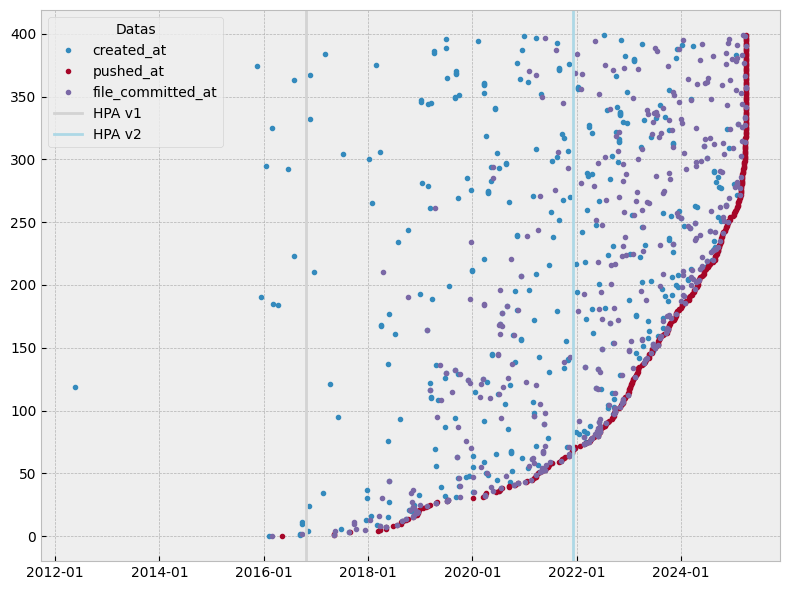

In [37]:
def dates_scatter_plot(df):
    plt.figure(figsize=(8, 6))
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

    plt.plot(df['created_at'], df.index,
            marker='.', linestyle='', label='created_at')
    plt.plot(df['pushed_at'], df.index,
            marker='.', linestyle='', label='pushed_at')
    plt.plot(df['file_committed_at'], df.index,
            marker='.', linestyle='', label='file_committed_at')
    plt.axvline(x=releasedate_hpav1, color='lightgray', label="HPA v1")
    plt.axvline(x=releasedate_hpav2, color='lightblue', label="HPA v2")

    plt.legend(title='Datas')

    plt.tight_layout()
    plt.show()

dates_scatter_plot(details_dates)


In [38]:
details_dates_active = details_dates[details_dates['pushed_at'] >= "2025-01-01"].copy().reset_index()

details_dates_active

,index,created_at,pushed_at,file_committed_at,apiVersion,hpaVersion
0,256,2023-01-24 17:36:38+00:00,2025-01-07 23:16:20+00:00,2023-02-06 11:01:02+00:00,autoscaling/v1,v1
1,257,2023-08-30 01:24:51+00:00,2025-01-09 04:55:23+00:00,2023-12-01 02:25:00+00:00,autoscaling/v2,v2
2,258,2021-07-02 22:15:22+00:00,2025-01-11 23:41:15+00:00,2022-11-26 05:12:30+00:00,autoscaling/v2,v2
3,259,2023-12-20 16:16:42+00:00,2025-01-12 05:16:03+00:00,2024-07-28 14:47:36+00:00,autoscaling/v1,v1
4,260,2022-03-15 12:17:08+00:00,2025-01-23 02:13:24+00:00,2023-04-01 02:33:37+00:00,autoscaling/v1,v1
...,...,...,...,...,...,...
139,395,2022-11-10 00:03:39+00:00,2025-04-03 09:52:51+00:00,2024-01-17 20:20:33+00:00,autoscaling/v2,v2
140,396,2019-06-27 11:45:31+00:00,2025-04-03 11:03:09+00:00,2024-12-03 06:07:35+00:00,autoscaling/v2,v2
141,397,2021-03-25 12:33:05+00:00,2025-04-03 11:26:46+00:00,2021-05-20 23:58:29+00:00,autoscaling/v2beta2,v2
142,398,2020-12-31 05:47:19+00:00,2025-04-03 11:40:32+00:00,2025-03-27 12:13:11+00:00,autoscaling/v2,v2


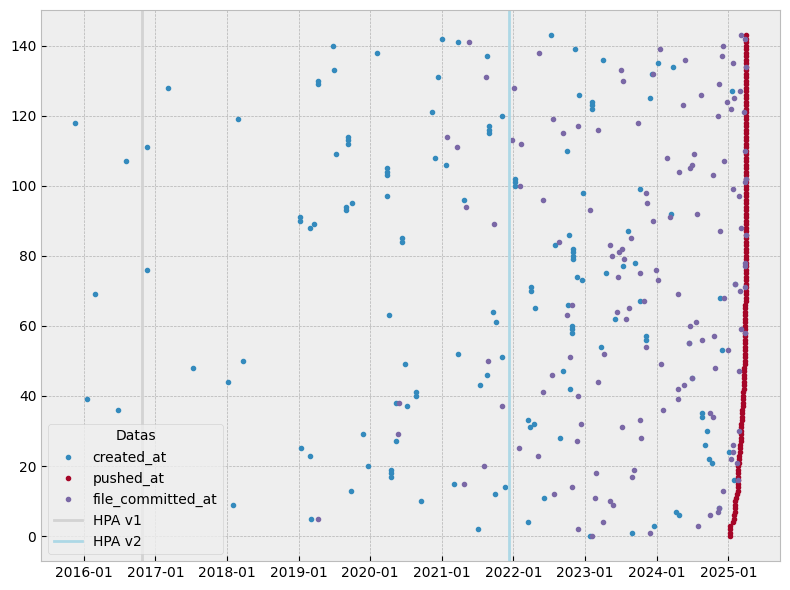

In [39]:
dates_scatter_plot(details_dates_active)#.sort_values('created_at', ignore_index=True, inplace=False, ascending=True))

In [40]:
details_dates_v2 = details_dates_active[details_dates_active['hpaVersion'] == 'v2'].copy().reset_index()

details_dates_v2

,level_0,index,created_at,pushed_at,file_committed_at,apiVersion,hpaVersion
0,1,257,2023-08-30 01:24:51+00:00,2025-01-09 04:55:23+00:00,2023-12-01 02:25:00+00:00,autoscaling/v2,v2
1,2,258,2021-07-02 22:15:22+00:00,2025-01-11 23:41:15+00:00,2022-11-26 05:12:30+00:00,autoscaling/v2,v2
2,5,261,2019-03-07 11:32:00+00:00,2025-01-28 17:30:25+00:00,2019-04-11 10:52:22+00:00,autoscaling/v2beta1,v2
3,6,262,2024-04-23 02:28:19+00:00,2025-01-30 01:41:00+00:00,2024-10-01 21:27:50+00:00,autoscaling/v2,v2
4,7,263,2024-04-09 07:13:38+00:00,2025-02-03 01:07:01+00:00,2024-11-11 12:41:52+00:00,autoscaling/v2,v2
...,...,...,...,...,...,...,...
105,138,394,2020-02-06 18:07:31+00:00,2025-04-03 09:10:36+00:00,2022-05-09 23:39:10+00:00,autoscaling/v2beta1,v2
106,139,395,2022-11-10 00:03:39+00:00,2025-04-03 09:52:51+00:00,2024-01-17 20:20:33+00:00,autoscaling/v2,v2
107,140,396,2019-06-27 11:45:31+00:00,2025-04-03 11:03:09+00:00,2024-12-03 06:07:35+00:00,autoscaling/v2,v2
108,141,397,2021-03-25 12:33:05+00:00,2025-04-03 11:26:46+00:00,2021-05-20 23:58:29+00:00,autoscaling/v2beta2,v2


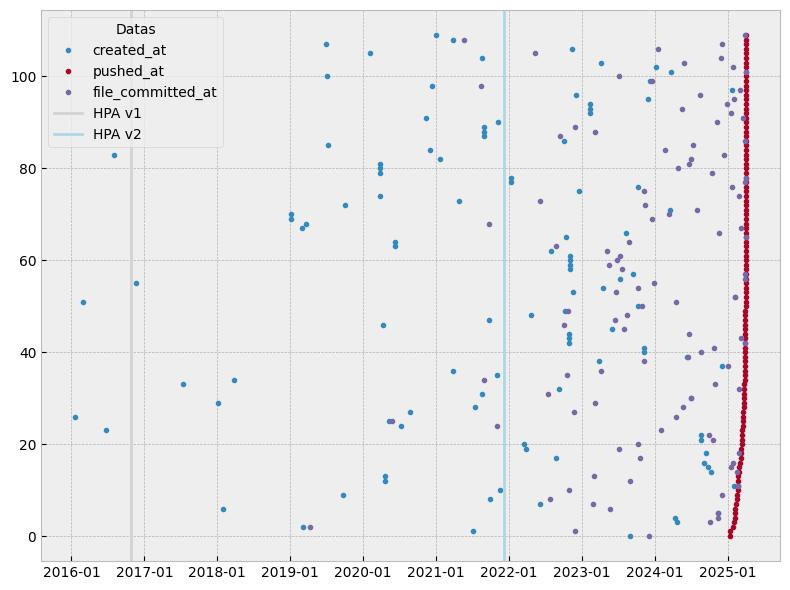

In [41]:
dates_scatter_plot(details_dates_v2)#.sort_values('created_at', ignore_index=True, inplace=False, ascending=True))

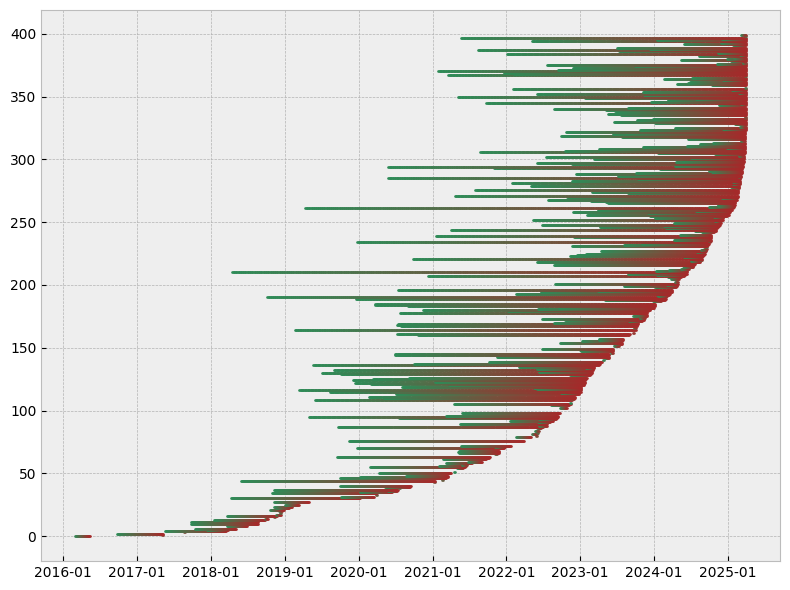

In [42]:
def timeline_plot(df):
    plt.figure(figsize=(8, 6))
    num_rows = df.shape[0]
    oldest_file_at = df['file_committed_at'].sort_values(inplace=False).iloc[0]
    if releasedate_hpav1 > oldest_file_at.replace(tzinfo=None):
        plt.axvline(x=releasedate_hpav1, color='lightgray', label="HPA v1")
    plt.axvline(x=releasedate_hpav2, color='lightblue', label="HPA v2")

    for i in df.index:
        # x1 = df.loc[i, 'created_at']
        x2 = df.loc[i, 'file_committed_at']
        x3 = df.loc[i, 'pushed_at']
        normalized_i = i / (num_rows - 1) if num_rows > 1 else 0.5
        plt.plot([x2, x3], [i, i], marker='.', linewidth=1)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.tight_layout()
    plt.show()


def timeline_collection(df):
    fig, ax = plt.subplots(figsize=(8, 6))
    segments = []
    color_values = []

    start_num = mdates.date2num(df['file_committed_at'])
    end_num = mdates.date2num(df['pushed_at'])

    num_points = 200

    cmap = LinearSegmentedColormap.from_list("DrdDbu", ["seagreen", "brown"])

    for i in df.index:
        start = df.loc[i, 'file_committed_at']
        end = df.loc[i, 'pushed_at']

        start_num = mdates.date2num(start)
        end_num = mdates.date2num(end)

        x_seq = np.linspace(start_num, end_num, num_points)
        y_seq = np.full(num_points, i, dtype=float)

        for j in range(num_points - 1):
            seg = [
                (x_seq[j], y_seq[j]),
                (x_seq[j+1], y_seq[j+1])
            ]
            color = (j / num_points -1)
            segments.append(seg)
            color_values.append(color)
    
    lc = LineCollection(segments, array=np.array(color_values), cmap=cmap, linewidth=2)
    lc.set_joinstyle('round')
    lc.set_capstyle('round')
    ax.add_collection(lc)

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.autoscale_view()
    plt.tight_layout()
    plt.show()


timeline_collection(details_dates)


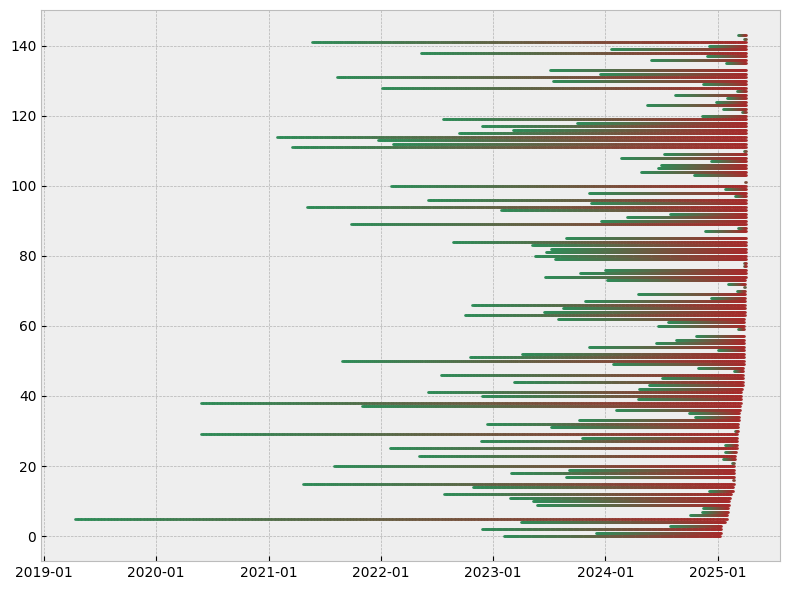

In [43]:
timeline_collection(details_dates_active)

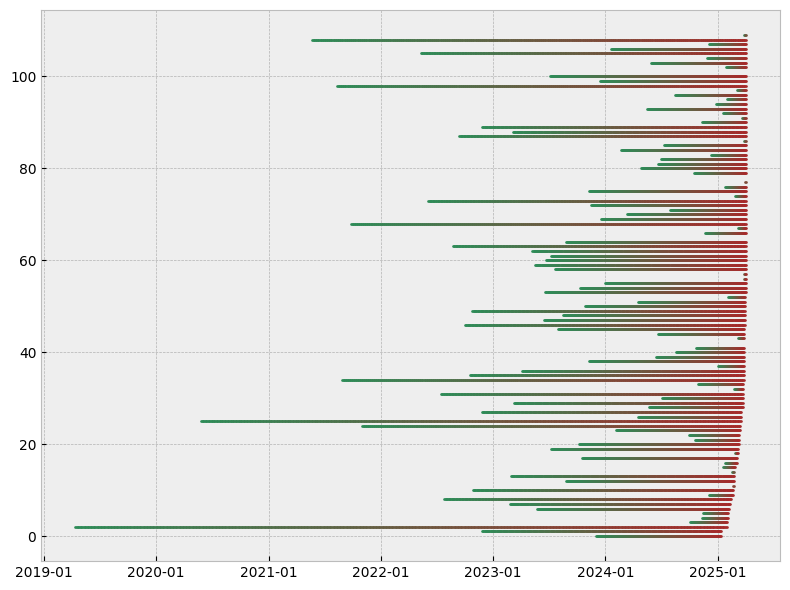

In [44]:
timeline_collection(details_dates_v2)

In [99]:
items_details[items_details['Owner'] == 'GoogleCloudPlatform']

,Owner,Project,File Path,hpa_count,apiVersion,Is Helm Template,Metric Name,Metric Type,Target Value,Has Behavior,stargazers_count,created_at,pushed_at,file_committed_at,message
124,GoogleCloudPlatform,anthos-service-mesh-packages,search_results/GoogleCloudPlatform/anthos-service-mesh-packages/samples/gateways/istio-egressgateway/autoscaling-v2beta1.yaml,1,autoscaling/v2beta1,False,cpu,Resource,None,False,136,2020-02-06T18:07:31Z,2025-04-03T09:10:36Z,2022-05-09T23:39:10Z,"Add new hpa and pdb versions for samples (#1191)\n\n* Add new hpa and pdb versions for samples\r\n\r\n* Add changes for egress, fix version and comments"
125,GoogleCloudPlatform,anthos-service-mesh-samples,search_results/GoogleCloudPlatform/anthos-service-mesh-samples/docs/ingress-gateway-external-lb/ingress-gateway-nonroot.yaml,1,autoscaling/v2,False,cpu,Resource,80,False,42,2020-06-10T17:07:29Z,2025-04-01T03:02:53Z,2023-08-25T15:29:53Z,Run as non-root with limited privileges (#195)
126,GoogleCloudPlatform,anthos-service-mesh-samples,search_results/GoogleCloudPlatform/anthos-service-mesh-samples/docs/ingress-gateway-external-lb/ingress-gateway.yaml,1,autoscaling/v2,False,cpu,Resource,80,False,42,2020-06-10T17:07:29Z,2025-04-01T03:02:53Z,2022-08-22T21:30:20Z,Ingress gateway external lb (#89)\n\n* Added ingress-gateway-external-lb sample\r\n\r\n* Switched to istio: ingressgateway label\r\n\r\n* Added additional comments\r\n\r\n* Added a new line at the end of the file
127,GoogleCloudPlatform,click-to-deploy-solutions,search_results/GoogleCloudPlatform/click-to-deploy-solutions/gke-autopilot-hpa/build/hpa-example.yaml,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,50,False,95,2022-12-16T18:26:08Z,2025-03-31T10:43:21Z,2024-01-06T16:46:28Z,refactor gke-hpa
128,GoogleCloudPlatform,apigee-anthos-service-mesh-demo,search_results/GoogleCloudPlatform/apigee-anthos-service-mesh-demo/api-ingress/kubernetes-manifests/deployment.yaml,1,autoscaling/v2,False,cpu,Resource,80,False,39,2022-04-20T00:11:55Z,2025-03-28T22:43:36Z,2023-08-14T21:45:18Z,fix: update to api-ingress CRD latest version
131,GoogleCloudPlatform,cloud-builders,search_results/GoogleCloudPlatform/cloud-builders/gke-deploy/deployer/testing/expected-suggested/no-config.yaml,1,autoscaling/v2,False,cpu,Resource,80,False,1392,2016-06-21T17:01:33Z,2025-03-12T22:13:00Z,2024-02-02T20:44:49Z,Update horizintal pod autoscalar to v2\n\nThis PR updates horizontal pod autoscalar to v2.
132,GoogleCloudPlatform,cloud-learning-platform,search_results/GoogleCloudPlatform/cloud-learning-platform/microservices/prior_learning_assessment/kustomize/custom/hpa.yaml,1,autoscaling/v2,False,cpu,Resource,60,False,34,2022-10-31T14:04:20Z,2025-03-31T22:30:07Z,2023-07-08T14:20:35Z,fix: deployment issue
133,GoogleCloudPlatform,cloud-learning-platform,search_results/GoogleCloudPlatform/cloud-learning-platform/microservices/student_learner_profile/kustomize/prod/hpa.yaml,1,autoscaling/v2,False,cpu,Resource,60,False,34,2022-10-31T14:04:20Z,2025-03-31T22:30:07Z,2023-07-20T10:26:39Z,Updated HPA version v2beta1 to v2
134,GoogleCloudPlatform,cloud-learning-platform,search_results/GoogleCloudPlatform/cloud-learning-platform/microservices/lti/kustomize/prod/hpa.yaml,1,autoscaling/v2,False,cpu,Resource,60,False,34,2022-10-31T14:04:20Z,2025-03-31T22:30:07Z,2023-05-17T12:25:14Z,Updated API version in hpa manifests
136,GoogleCloudPlatform,cloud-learning-platform,search_results/GoogleCloudPlatform/cloud-learning-platform/microservices/dashboard/kustomize/custom/hpa.yaml,1,autoscaling/v2,False,cpu,Resource,60,False,34,2022-10-31T14:04:20Z,2025-03-31T22:30:07Z,2023-06-23T04:15:00Z,Added dashboard service from ailearning-backend into CLP


In [118]:
def repo_timeline(row):
    file_commits = get_file_commits(row)
    
    data = {
        'repo': f"{row['Owner']}/{row['Project']}",
        'created': row['created_at'],
        'last_commit': row['pushed_at'],
        'file_first_commit': file_commits[-1]['commit']['author']['date'],
        'file_last_commit': file_commits[0]['commit']['author']['date']
    }
    return pd.DataFrame(data=data, index=[row.name])

# repo_timeline(items_details.loc[131])

commit_marks = Parallel(n_jobs=32)(
    delayed(repo_timeline)(row) for _, row in items_details.iterrows()
)


In [119]:
df_commit_marks = pd.concat(commit_marks)

df['created'] = pd.to_datetime(df_commit_marks['created'])
df['last_commit'] = pd.to_datetime(df_commit_marks['last_commit'])
df['file_first_commit'] = pd.to_datetime(df_commit_marks['file_first_commit'])
df['file_last_commit'] = pd.to_datetime(df_commit_marks['file_last_commit'])


In [120]:
df_commit_marks_ordered = df_commit_marks.sort_values('last_commit', inplace=False, ignore_index=False, ascending=True)

In [121]:
df_commit_marks_ordered[df_commit_marks_ordered['repo'].str.startswith('GoogleCloudPlatform')]

,repo,created,last_commit,file_first_commit,file_last_commit
131,GoogleCloudPlatform/cloud-builders,2016-06-21T17:01:33Z,2025-03-12T22:13:00Z,2019-11-25T16:56:21Z,2024-02-02T20:44:49Z
128,GoogleCloudPlatform/apigee-anthos-service-mesh-demo,2022-04-20T00:11:55Z,2025-03-28T22:43:36Z,2022-04-22T19:23:17Z,2023-08-14T21:45:18Z
127,GoogleCloudPlatform/click-to-deploy-solutions,2022-12-16T18:26:08Z,2025-03-31T10:43:21Z,2024-01-06T16:46:28Z,2024-01-06T16:46:28Z
133,GoogleCloudPlatform/cloud-learning-platform,2022-10-31T14:04:20Z,2025-03-31T22:30:07Z,2023-05-23T10:54:25Z,2023-07-20T10:26:39Z
134,GoogleCloudPlatform/cloud-learning-platform,2022-10-31T14:04:20Z,2025-03-31T22:30:07Z,2022-12-22T10:17:05Z,2023-05-17T12:25:14Z
132,GoogleCloudPlatform/cloud-learning-platform,2022-10-31T14:04:20Z,2025-03-31T22:30:07Z,2023-07-06T13:24:50Z,2023-07-08T14:20:35Z
135,GoogleCloudPlatform/cloud-learning-platform,2022-10-31T14:04:20Z,2025-03-31T22:30:07Z,2022-12-22T10:17:05Z,2023-05-17T12:25:14Z
136,GoogleCloudPlatform/cloud-learning-platform,2022-10-31T14:04:20Z,2025-03-31T22:30:07Z,2023-06-23T04:15:00Z,2023-06-23T04:15:00Z
125,GoogleCloudPlatform/anthos-service-mesh-samples,2020-06-10T17:07:29Z,2025-04-01T03:02:53Z,2023-08-25T15:29:53Z,2023-08-25T15:29:53Z
126,GoogleCloudPlatform/anthos-service-mesh-samples,2020-06-10T17:07:29Z,2025-04-01T03:02:53Z,2022-08-22T21:30:20Z,2022-08-22T21:30:20Z


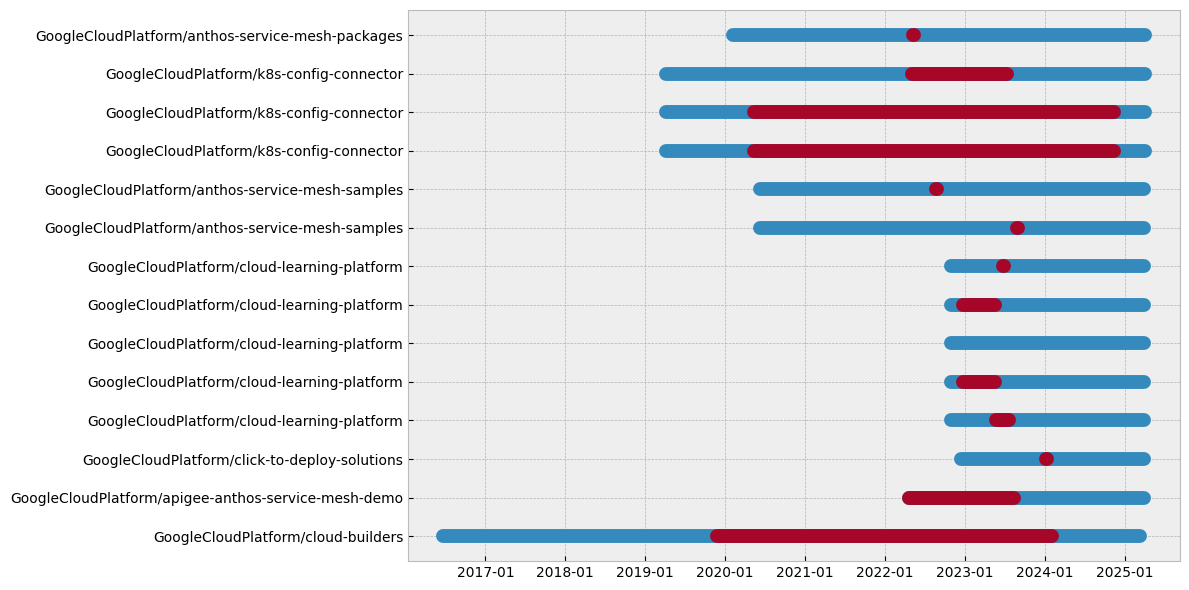

In [132]:
def repo_timeline_plot(df):
    fig, ax = plt.subplots(figsize=(12,6))

    # obtém as cores do tema utilizado em uma lista
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for i in range(df.shape[0]):
        x1 = mdates.datestr2num(df.iloc[i]['created'])
        x2 = mdates.datestr2num(df.iloc[i]['last_commit'])
        plt.plot(
            [x1, x2],
            [i, i],
            linewidth='10',
            solid_capstyle='round',
            color=colors[0]
        )

        x3 = mdates.datestr2num(df.iloc[i]['file_first_commit'])
        x4 = mdates.datestr2num(df.iloc[i]['file_last_commit'])
        # quando há apenas um commit, criar um valor mínimo para exibir no gráfico
        if x3 == x4:
            x4 = x4 + 5
        
        plt.plot(
            [x3, x4],
            [i, i],
            linewidth='10',
            solid_capstyle='round',
            color=colors[1]
        )

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())

    ax.set_yticks(range(0, df.shape[0]))
    ax.set_yticklabels(df['repo'])

    plt.tight_layout()
    plt.show()

repo_timeline_plot(df_commit_marks_ordered[df_commit_marks_ordered['repo'].str.startswith('GoogleCloudPlatform')])

In [34]:
display(df_commit_marks_ordered.iloc[80:92])

display(items_details.loc[481])


,repo,created,last_commit,file_first_commit,file_last_commit
459,bgastaldi/myapp,2021-10-22T13:45:31Z,2021-12-23T10:58:47Z,2021-11-05T11:32:41Z,2021-11-05T11:32:41Z
458,bgastaldi/myapp,2021-10-22T13:45:31Z,2021-12-23T10:58:47Z,2021-11-05T11:32:41Z,2021-11-05T11:32:41Z
364,a-nldisr/kubedemo,2021-03-23T16:51:24Z,2022-01-25T09:59:47Z,2021-05-22T09:40:55Z,2021-05-22T09:40:55Z
689,gbaeke/vscode-demo,2022-02-21T11:04:16Z,2022-02-22T09:33:09Z,2022-02-21T16:08:25Z,2022-02-21T16:08:25Z
802,issessions/ISSessionsCTF2022,2022-03-10T06:45:32Z,2022-03-10T06:47:49Z,2022-03-10T06:46:28Z,2022-03-10T06:46:28Z
798,issessions/ISSessionsCTF2022,2022-03-10T06:45:32Z,2022-03-10T06:47:49Z,2022-03-10T06:46:28Z,2022-03-10T06:46:28Z
797,issessions/ISSessionsCTF2022,2022-03-10T06:45:32Z,2022-03-10T06:47:49Z,2022-03-10T06:46:28Z,2022-03-10T06:46:28Z
799,issessions/ISSessionsCTF2022,2022-03-10T06:45:32Z,2022-03-10T06:47:49Z,2022-03-10T06:46:28Z,2022-03-10T06:46:28Z
801,issessions/ISSessionsCTF2022,2022-03-10T06:45:32Z,2022-03-10T06:47:49Z,2022-03-10T06:46:28Z,2022-03-10T06:46:28Z
800,issessions/ISSessionsCTF2022,2022-03-10T06:45:32Z,2022-03-10T06:47:49Z,2022-03-10T06:46:28Z,2022-03-10T06:46:28Z


Owner                                                               candidoma
Project                                                               testhpa
File Path            search_results/candidoma/testhpa/nginx/hpa_external.yaml
hpa_count                                                                   1
apiVersion                                                autoscaling/v2beta2
Is Helm Template                                                        False
Metric Name                                                       YOUR_METRIC
Metric Type                                                          External
Target Value                                                       YOUR_VALUE
Has Behavior                                                            False
stargazers_count                                                            2
created_at                                               2022-03-05T10:06:21Z
pushed_at                                                2022-03

,pushed_at,file_committed_at


,pushed_at,file_committed_at,last_commits
1332,2024-06-24 16:23:15+00:00,2024-05-15 20:20:52+00:00,39 days 20:02:23
1467,2024-11-11 00:24:46+00:00,2024-03-02 23:11:40+00:00,253 days 01:13:06
1269,2023-11-30 02:52:04+00:00,2023-11-30 02:51:53+00:00,0 days 00:00:11
353,2025-03-06 23:01:54+00:00,2022-12-13 07:04:55+00:00,814 days 15:56:59
195,2023-01-06 10:06:05+00:00,2022-05-19 12:37:17+00:00,231 days 21:28:48
...,...,...,...
532,2023-08-08 03:23:12+00:00,2023-08-08 03:23:06+00:00,0 days 00:00:06
535,2022-07-01 07:03:27+00:00,2019-09-20 18:58:20+00:00,1014 days 12:05:07
536,2024-10-10 20:35:12+00:00,2024-04-09 14:54:50+00:00,184 days 05:40:22
537,2024-10-10 20:35:12+00:00,2024-04-12 19:42:34+00:00,181 days 00:52:38


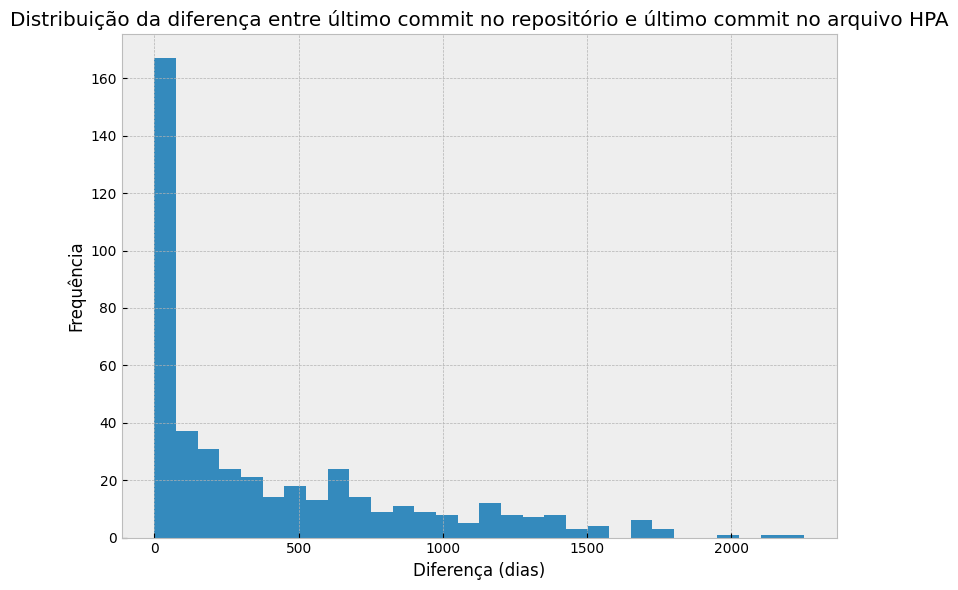

In [35]:
df_date_diff = items_details[['pushed_at', 'file_committed_at']].copy()

df_date_diff['pushed_at'] = pd.to_datetime(df_date_diff['pushed_at'])
df_date_diff['file_committed_at'] = pd.to_datetime(
    df_date_diff['file_committed_at'])

display(df_date_diff[df_date_diff['file_committed_at']
        >= df_date_diff['pushed_at']])

df_date_diff['last_commits'] = df_date_diff['pushed_at'] - \
    df_date_diff['file_committed_at']

display(df_date_diff)

plt.figure(figsize=(8, 6))

(df_date_diff['last_commits'] / pd.Timedelta(days=1)).hist(bins=30)

plt.xlabel("Diferença (dias)")
plt.ylabel("Frequência")
plt.title("Distribuição da diferença entre último commit no repositório e último commit no arquivo HPA")
plt.tight_layout()
plt.show()


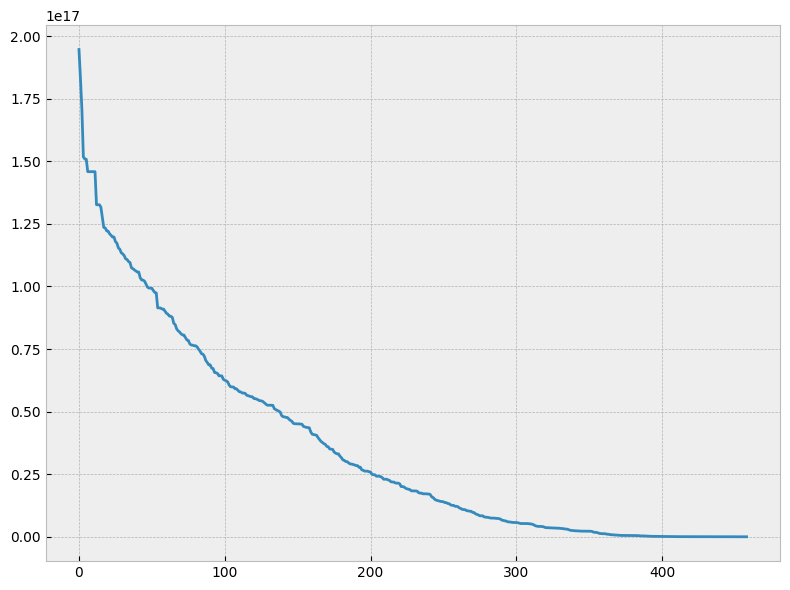

In [36]:
df_date_diff.sort_values('last_commits', inplace=True,
                         ignore_index=True, ascending=False)

cmap = plt.get_cmap('viridis')
num_rows = df_date_diff.shape[0]

plt.figure(figsize=(8, 6))

# for i in df_date_diff.index:
#     x1 = df_date_diff.loc[i, 'pushed_at']
#     x2 = df_date_diff.loc[i, 'file_committed_at']
#     normalized_i = i / (num_rows - 1) if num_rows > 1 else 0.5
#     color = cmap(normalized_i)
#     plt.plot(
#         [x1, x2], [i, i],
#         marker='.',
#         linewidth=1)#,
#         # color=color)

df_date_diff['last_commits'].plot()

plt.tight_layout()
plt.show()
